In [ ]:
import os
import sys
sys.path.append('./preproc/code')
sys.path.append("./src")

import numpy as np
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

import torch

from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Final Report

Developed by

- Sunghwan Moon, Jungmin Kim, Seunghyeon Park, Bojing Gui

## Introduction

### (1) Problem

With the emergence of edge devices such as apple watch and Fit-bit, the use of personalized health data is becoming more prevalent. Therefore, if we can make good use of personalized health data such as biometric signals in edge devices, we will be able to easily monitor our health conditions such as our sleep patterns.


However, due to the nature of the edge device, personalized health data cannot be shared with one another, limiting the learning of a huge quantity of data. Moreover, since it must be embedded in the edge device model, the size of the personalized model itself is limited.

Our problem setting is characterized by three main issues:

*  Lack of label in sleep stage classification label.
*  Existence of multimodalities in bio-signal data.
*  Downstream task for personalized model.

### (2) Related Work

- **FOCAL** Framework (GitHub)[] # to-do: add link to Github

    The FOCAL Framework, proposed in [FOCAL: Contrastive Learning for Multimodal Time-Series Sensing Signals in Factorized Orthogonal Latent Space, 2023], is a self-supervised multimodal contrastive framework. And, in this case, not only is shared information between sensory modalities extracted, but exclusive modality information is not explicitly considered, which could be essential to understanding the underlying sensing physics. We intend to integrate subject-aware learning to this strategy.

<img src="asset/FOCAL_figure.png" alt="focal" style="width:900px;">

- **Subject-Aware Contrastive Learning for Biosignals** (GitHub)[] # to-do: add link to Github

    This study presents a methodology for dealing with Intersubject variability when learning representations for biosignals. Intersubject variability can be interpreted as a different domain for each subject. The domain shift from subject to subject can be modeled and corrected with adversarial training. Through this adversarial training, the model can also be promoted to learn domain-invariant features. We also used adversarial training to learn subject invariant features in our learning methodology.

<img src="asset/subject_aware_image.png" alt="overview" style="width:900px;">

## Method

### Project Overview


In our big overview, we expect that the foundation model generates informative representative feature from large bio-signal dataset, and it can improve the downstream task in the restricted environment where people cannot share bio-signal data with others.

Specifically, we will attempt to develop the foundation model using bio-signal (ECG, Heart Rate) [1] for applying the sleep stage classification from the personal data of edge devices [2], such as Apple Watch or Fit-bit. It is hard to get high performance by only using personally own data from edge devices and to train the model, as limitation of the amount of data for train and low hardware resources of edge devices. We expect that the foundation model generates informative representative feature from large bio-signal dataset, and it can improve the downstream task in the restricted environment that people cannot share bio-signal data to others.

<img src="asset/overall_task_architecture.png" alt="overview" style="width:900px;">

### Foundation Model


We present the issue that the personalized model in the edge device lacks sufficient data to learn each personalized model. We intend to suggest a solution to the problem by creating a foundation model from a huge amount of bio-signal data that has been made public and improving the performance of the personalized model in the edge device using the foundation model. We plan to develop a foundation model that takes into account each of the 3 issues we established for the problem setting .

Our proposed strategy involves using a huge quantity of publically available bio-signal data to build a foundation model, which can then be used to improve the performance of personalized models on edge devices. By leveraging the representation power of the foundation model, we expect the personalized sleep stage classification model to get better performance than the case with a classification model without the foundation model. Previous studies focusing on points each existed, but did not take into account of all the relevant factors essential for the personalized model, so we newly propose the following model satisfiying these points.

<img src="asset/foundation_model_structure.png" alt="FMArch" style="width:900px;">

#### 1. Multi Modal Contrastive Learning

##### 1-1 Contrastive Loss function

First, we tried to fully utilize various modalities in public datset in order to create an advanced foundation model.

To fully utilize the multimodal signal, contrastive learning was constructed by dividing the shared features and each private features.

1) How to construct positive and negative pair

2) Shared/Private/Orthogonal features

##### 1-2 Subject Invariant

In addition, for subject aware learning, we trained a sub-classifier to classify the subject using a hidden vector in the encoder, and we used the subject loss as an adversarial loss to induce the encoder to learn the subject invariant feature.


1-2-1 adversarial classifier
 - adfadfadf
 - adfadfadsf
 - adfadfa


1-2-2 subject invariance loss
 - adfadfadf
 - adfadfadsf
 - adfadfa

##### 1-3 Backbone Model for contrastive learning


1-3-1 Deepsense 

The backbone model chosen for contrastive learning was based on the Deepsense model ([ref](https://arxiv.org/abs/1611.01942)) and the tinysleepnet model ([ref](https://github.com/akaraspt/tinysleepnet)). These models use convolutional layers followed by LSTM layers, which capture sequential features, to extract biosignal information. The architecture of the model is shown below. 

- Reference: [GitHub](https://github.com/akaraspt/tinysleepnet) Link


<img src="asset/backbone data.png" alt="DeepSence" style="width:600px;">

### Downstream

#### 1. Baseline

##### 1-1 DeepSense

The architecture for the downstream classifier is shown below. This will be used as the baseline comparison for our model. The neural network will take in the two inputs, heart rate and ECG. The ECG will be processed through convolutional layers and a LSTM before the inputs are concatenated and fully connected layers are used for classification.

#### 2. Classifier With Foundation Model

##### 2-1 Feed forward classifier - Foundation downstream classifier

## Experiment

### 1. Dataset (to-do: Victoria, [Change the 내용])

We used 356,062 samples from the public MESA data set of 125 subjects out of 6,814. And we chose to use ECG and Heart rate for modality since we could only gain those two from the apple watch data. And we collected individual apple watch dataset from 5 friends to perform our downstream task. We made a subject segment pair for our contrastive learning and we splitted the data into portion of 100 by 25 by 25.




<img src="asset/data_description_table.png" alt="DataTable" style="width:900px;">

### 2. Preprocessing (to-do: Victoria, [Change the 내용])

1) MESA data
- We needs to segment the bio signal (heart rate and ecg) to 30 seconds (1 epoch) because sleep stage is decided from 30 seconds data in down stream
- We select validation epoch without any problems, such as disconnection error, mis-collection time between bio signals.

- Heart Rate
    - After selecting validation epoch, the heart rate was **interpolated** to have a value for every 1 second, **smoothed** and **filtered** to amplify periods of high change by convoloving with a diffrence of Gaussian filter and **normalized** by dividing by the 90th percentile in the absolute diffrence between each heart rate measurement and the mean heart rate over the sleep periods
- Electrocardiogram (ECG=EKG)
    - After selecting validation epoch, the ECG was **smoothed** and **filtered** by Gaussian filter for denoising the ECG


2) Apple watch data
- We collected Apple watch data which contains heart rate and acceleration
- We plan to preprocess it following the previous study titled "**Sleep stage prediction with raw acceleration and photoplethysmography heart rate data derived from a consumer wearable device** (Olivia, et al.)"


3) Generating Data Pair

- explain ~~~~
- explain ~~

##### 2-1-1 Preprocessing MESA
We preprocessed bio signals (Heart Rate & ECG) like below

- **Heart Rate**
    - After selecting validation epoch, the heart rate was **interpolated** to have a value for every 1 second, **smoothed** and **filtered** to amplify periods of high change by convoloving with a diffrence of Gaussian filter and **normalized** by dividing by the 90th percentile in the absolute diffrence between each heart rate measurement and the mean heart rate over the sleep periods
- **Electrocardiogram (ECG=EKG)**
    - After selecting validation epoch, the ECG was **smoothed** and **filtered** by Gaussian filter for denoising the ECG

In [ ]:
from apple import generate_data_to_dic, filter_to_epoch
from mesa import mesa_preprocessing, get_subject_ids

In [ ]:
DATAPATH = None # For privay reasons, the path to the data is not provided
subject_ids = get_subject_ids(PATH=os.path.join(DATAPATH, "./mesa/polysomnography/annotations-events-nsrr"))
len(subject_ids)

SAVEPATH= None # For privay reasons, the path to the data is not provided
Error = mesa_preprocessing(subject_ids, savepath=SAVEPATH)

In [ ]:
csv_datapath = None # For privay reasons, the path to the data is not provided

for subj in subject_ids:

    if subj not in Error:
        activity = np.load(SAVEPATH+subj+"_activity_count.npy").reshape(-1)
        hr = np.load(SAVEPATH+subj+"_heart_rate.npy").reshape(-1)
        ecg = np.load(SAVEPATH+subj+"_ecg.npy").reshape(-1)
        ecg = -ecg
        psg_status = np.load(SAVEPATH+subj+"_labeled_sleep.npy").squeeze()
        repeat_psg = []
        repeat_cosine = []
        session = []
        session_ecg = []
        psg_ecg = []

        ses = 0

        for i, psg in enumerate(psg_status):
            repeat_psg.extend([psg]*30)            
            session.extend([ses]*30)
            session_ecg.extend([ses]*256)
            psg_ecg.extend([psg]*256)
            
            ses += 1

        print(np.array(activity).shape, np.array(hr).shape, np.array(ecg).shape, len(repeat_psg), len(psg_ecg), len(session_ecg))

        df = pd.DataFrame({'activity_count': activity, 'heart_rate': hr, 'session_id':session, 'psg_status': repeat_psg})
        df_ecg = pd.DataFrame({"ECG":ecg, 'session_id':session_ecg, 'psg_status': psg_ecg})
        
        df.to_csv(csv_datapath, index=False)
        df_ecg.to_csv(csv_datapath, index=False)

After the preprocessing, we filtered **1,405 subjects** among 2,056 after quality contorl and, finally, we select **100 subjects** for training our foundation model.
The total segments we used is XXXX (1 epoch during 30s).

Below image show the result of preprocessing on **subject0001** from MESA dataset

[ECG]

<img src="asset/ecg_0001.png" alt="ECG_MESA" style="width:900px;">

[Heart Rate]

<img src="asset/heartrate_0001.png" alt="ECG_MESA" style="width:900px;">

[Sleep Stage]

<img src="asset/psg_0001.png" alt="ECG_MESA" style="width:900px;">

##### 2-1-2 Preprocessing Apple watch
- We collect 5 real Apple watch dataset which was collected during 7 days
- We preprocessed dataset with same pipeline with MESA dataset


In [ ]:
PATH = None # For privay reasons, the path to the data is not provided

subject_ids = []
for n, filename in enumerate(os.listdir(PATH)):
    filename = filename.split('_')
    subject_id = int(filename[0])

    if subject_id not in subject_ids:
        subject_ids.append(subject_id)
    
# sort the list
sorted_subject_ids = sorted(subject_ids)
np.array(sorted_subject_ids)

In [ ]:
save_path = None # For privay reasons, the path to the data is not provided

apple_data = generate_data_to_dic(PATH,
                                  second_column_step=1,val_to_fill_nans=-100,
                                  print_analysis=False)


for subj in sorted_subject_ids:
    savepath = "../data/watch/processed/temp/subject_" + str(subj) + ".csv"
    apple_data[subj].to_csv(savepath, index=False)


df, psg_status = filter_to_epoch("../data/watch/processed/temp/", bin_size=30)

for subj in sorted_subject_ids:
    ses_id = psg_status[subj].keys()
    last_ses = list(ses_id)[-1]
    stage = psg_status[subj].values()
    
    temp = pd.DataFrame({'session_id': ses_id, 'new_psg_status': stage})
    
    new_df = pd.merge(df[subj], temp, on='session_id')
    new_df.drop(columns=["psg_status"], inplace=True)
    
    new_df.rename(columns={'new_psg_status': 'psg_status'}, inplace=True)
    
    last_info = new_df[new_df['session_id'] == last_ses]
    
    if len(last_info) != 30:
        new_df.drop(new_df[new_df['session_id'] == last_ses].index, inplace=True)
    
    savepath = save_path + str(subj) + ".csv"
    new_df.to_csv(savepath, index=False)

##### 2-2 Generating Pair dataset for Contrastive Learning

In [ ]:
data_directory = None # For privay reasons, the path to the data is not provided
save_dir = None # For privay reasons, the path to the data is not provided

datas = os.listdir(data_directory)
datas.sort()
datas = datas[:4*100]
ecg_datas = [data for data in datas if 'ecg' in data]
hr_datas = [data for data in datas if 'heart_rate' in data]
sleep_datas = [data for data in datas if 'sleep' in data]
act_datas = [data for data in datas if 'activity' in data]

subj_data = {'ecg':ecg_datas, 'hr': hr_datas, 'stage':sleep_datas, 'act':act_datas}

In [ ]:
def make_pair(ecg, hr, sleep, act, subject_idx, subject_id, savepath):

    for seg_idx in range(len(sleep)):

        ecg_data = ecg.squeeze()[seg_idx]
        hr_data = hr.squeeze()[seg_idx]
        sleep_data = sleep.squeeze()[seg_idx]
        act_data = act.squeeze()[seg_idx]

        data_dict = {
                    'ecg': ecg_data,
                    'hr': hr_data,
                    'stage': sleep_data,
                    'activty': act_data,
                    'subject_idx': subject_idx
                    }
        
        savepath = os.path.join(save_dir, f'{subject_id}_{seg_idx}.npz')
        np.savez(savepath, **data_dict)

In [ ]:
for i in tqdm(range(100)):

    ecg = subj_data['ecg'][i]
    hr = subj_data['hr'][i]
    sleep = subj_data['stage'][i]
    act = subj_data['act'][i]
    
    ecg_list = np.load(os.path.join(data_directory, ecg))
    hr_list = np.load(os.path.join(data_directory, hr))
    sleep_list = np.load(os.path.join(data_directory, sleep))
    act_list = np.load(os.path.join(data_directory, act))
    real_subject = ecg.split('_')[0]

    make_pair(ecg_list, hr_list, sleep_list, act_list, i, real_subject, save_dir)

### 3. Training

#### (1) Training Foundation Model

In [ ]:
sys.path.append('./src/foundation')
import os
import sys
sys.path.append('./')

import args
import datetime
from tqdm import tqdm

import torch
import numpy as np
from models.AdversarialModel import AdversarialModel
from models.FOCALModules import FOCAL
from models.loss import FOCALLoss
from models.Backbone import DeepSense
from trainutils.metric import save_metrics

from data.Dataset import MESAPairDataset
from data.Augmentaion import init_augmenter

##### Function of Training

In [ ]:
def train_SA_Focal(train_loader, valid_loader, model, advs_model, 
                   optimizer, advs_optimizer, focal_loss_fn, args):
    torch.manual_seed(args.SEED)
    torch.cuda.manual_seed(args.SEED)
    torch.cuda.manual_seed_all(args.SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    start_time = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    model_save_dir = args.trainer_config["model_save_dir"]
    model_save_dir = os.path.join(model_save_dir, start_time)
    
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    trainer_config = args.trainer_config
    log_save_dir = args.trainer_config["log_save_dir"]
    
    model_save_format = args.model_save_format
    model_save_format["focal_config"] = args.focal_config
    model_save_format['subj_invariant_config'] = args.subj_invariant_config
    model_save_format['trainer_config'] = args.trainer_config
    model_save_format['data_config'] = args.data_config
    
    aug_1_name = args.data_config['augmentation'][0]
    aug_1_config = args.data_config['augmenter_config'].get(aug_1_name, {})
    aug_2_name = args.data_config['augmentation'][1]
    aug_2_config = args.data_config['augmenter_config'].get(aug_2_name, {})
    
    aug_1 = init_augmenter(aug_1_name, aug_1_config)
    aug_2 = init_augmenter(aug_2_name, aug_2_config)
    
    model.train()
    best_val_loss = float('inf')
    
    train_focal_losses, val_focal_losses = [], []
    train_advs_losses = []
    train_accuracies = []
    
    for ep in tqdm(range(trainer_config['epochs'])):
        
        model.train()
        advs_model.train()
        focal_loss_fn.train()
        
        # Save Result
        focal_train_loss = 0
        running_advs_train_loss = 0
        
        correct_preds = 0
        total_preds = 0
        
        
        for raw_modal_1, raw_modal_2, subj_label, sleep_label in train_loader:
            raw_modal_1, raw_modal_2, subj_label, sleep_label = raw_modal_1.to(args.focal_config["device"]), raw_modal_2.to(args.focal_config["device"]), subj_label.to(args.focal_config["device"]), sleep_label.to(args.focal_config["device"]) # [B, 30], [B, 30*256], [B, 1]
            
            aug_1_modal_1 = aug_1(raw_modal_1)
            aug_2_modal_1 = aug_2(raw_modal_1)
            
            aug_1_modal_2 = aug_1(raw_modal_2)
            aug_2_modal_2 = aug_2(raw_modal_2)
            
            # For updating the only advs_model (classifier)
            for param in model.parameters():
                param.requires_grad = False
            for param in advs_model.parameters():
                param.requires_grad = True
                
            advs_optimizer.zero_grad()
            
            # Using Encoder for classify the subject
            enc_feature_1, enc_feature_2 = model(aug_1_modal_1, aug_1_modal_2, aug_2_modal_1, aug_2_modal_2, proj_head=True)
            
            # Predict the subject
            subj_pred = advs_model(enc_feature_1, enc_feature_2) 
            advs_loss = advs_model.forward_adversarial_loss(subj_pred, subj_label)
            
            advs_loss.backward()
            advs_optimizer.step()
            
            running_advs_train_loss += advs_loss.item()
            
            # For efficient memory management
            del enc_feature_1, enc_feature_2, subj_pred, advs_loss
            
            # For updating the only Focal model (SSL model)
            for param in model.parameters():
                param.requires_grad = True
            for param in advs_model.parameters():
                param.requires_grad = False
            
            optimizer.zero_grad()

            enc_feature_1, enc_feature_2 = model(aug_1_modal_1, aug_1_modal_2, aug_2_modal_1, aug_2_modal_2, proj_head=True)
            
            subj_pred = advs_model(enc_feature_1, enc_feature_2) 
            subj_invariant_loss = advs_model.forward_subject_invariance_loss(subj_pred, subj_label)
            
            focal_loss = focal_loss_fn(enc_feature_1, enc_feature_2, subj_invariant_loss) # To-Do -> add regularization term about subject invariant
            focal_loss.backward()
            optimizer.step()
            
            focal_train_loss += focal_loss.item()
            
            # Calculate accuracy
            preds = torch.argmax(subj_pred, dim=1)
            correct_preds += (preds == subj_label).sum().item()
            total_preds += subj_label.size(0)
            
            # For efficient memory management
            del enc_feature_1, enc_feature_2, subj_pred, focal_loss
            torch.cuda.empty_cache()
            
        # Calculate and store train accuracy and losses for plotting
        train_accuracy = correct_preds / total_preds
        train_accuracies.append(train_accuracy)
        train_advs_losses.append(running_advs_train_loss / len(train_loader))
        train_focal_losses.append(focal_train_loss / len(train_loader))
        
        print(f"Epoch {ep} - Adversarial Loss: {running_advs_train_loss / len(train_loader)}, \
            Focal Loss: {focal_train_loss / len(train_loader)}, Accuracy: {train_accuracy}")
                
        if ep % trainer_config['val_interval'] == 0:
            model.eval()
            advs_model.eval()
            focal_loss_fn.eval()
            
            focal_val_loss = 0
            
            for raw_modal_1, raw_modal_2, subj_label, sleep_label in valid_loader:
                raw_modal_1, raw_modal_2, subj_label, sleep_label = raw_modal_1.to(args.focal_config["device"]), raw_modal_2.to(args.focal_config["device"]), \
                                                                    subj_label.to(args.focal_config["device"]), sleep_label.to(args.focal_config["device"])
                
                with torch.no_grad():
                    enc_feature_1, enc_feature_2 = model(raw_modal_1, raw_modal_2, raw_modal_1, raw_modal_2, proj_head=True)                    
                    focal_loss = focal_loss_fn(enc_feature_1, enc_feature_2, 0) # To-Do -> add regularization term about subject invariant
                    focal_val_loss += focal_loss.item()
                    
                    # For efficient memory management
                    del enc_feature_1, enc_feature_2, focal_loss
                    torch.cuda.empty_cache()
                    
            print("-----"*20)
            print(f"(Validation) Epoch{ep} - Focal Loss: {focal_val_loss/ len(valid_loader)}")                    
            
            val_focal_losses.append(focal_val_loss / len(valid_loader))
                            
            if focal_val_loss < best_val_loss:
                best_val_loss = focal_val_loss
                
                time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                focal_model_checkpoint = os.path.join(model_save_dir, f'SSL_focal_model_ep_{ep}.pth')
                
                # Save ckpt & arguments
                model_save_format["train_acc"] = train_accuracy
                model_save_format["train_loss"] = focal_train_loss / len(train_loader)
                model_save_format["val_loss"] = focal_val_loss / len(valid_loader)
                model_save_format["train_epoch"] = ep
                model_save_format["focalmodel_path"] = focal_model_checkpoint
                model_save_format["focal_state_dict"] = model.state_dict()
                model_save_format['advs_state_dict'] = advs_model.state_dict()
                
                torch.save(model_save_format, focal_model_checkpoint)                
                
                print(f"Model Saved - Focal Model: {focal_model_checkpoint}")
            print("-----"*20)
    
    LOGPATH = os.path.join(args.trainer_config["log_save_dir"], f'SSL_focal_log_{start_time}.npz')
    train_log = np.array([train_focal_losses, val_focal_losses, train_accuracies, train_advs_losses])
    np.savez(LOGPATH, train_log)
    
    save_metrics(train_focal_losses, val_focal_losses, train_accuracies, train_advs_losses, start_time)
                
def print_args(args):
    
    print("Data Configs:")
    for k, v in args.data_config.items():
        print(f"\t{k}: {v}")
    print("----------"*10)
    
    print("Focal Configs:")
    for k, v in args.focal_config.items():
        print(f"\t{k}: {v}")
    print("----------"*10)
    
    print("Subject Invariant Configs:")
    for k, v in args.subj_invariant_config.items():
        print(f"\t{k}: {v}")
    print("----------"*10)
    
    print("Trainer Configs:")
    for k, v in args.trainer_config.items():
        print(f"\t{k}: {v}")
    print("----------"*10)

##### Generate DataLoader

In [ ]:
print_args(args)

train_dataset = MESAPairDataset(file_path=args.data_config['train_data_dir'],
                                modalities=args.data_config['modalities'],
                                subject_idx=args.data_config['subject_key'],
                                stage=args.data_config['label_key'])
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                            batch_size=args.trainer_config['batch_size'],
                                            shuffle=True,
                                            num_workers=4)

val_dataset = MESAPairDataset(file_path=args.data_config['val_data_dir'],
                                modalities=args.data_config['modalities'],
                                subject_idx=args.data_config['subject_key'],
                                stage=args.data_config['label_key'])

val_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=args.trainer_config['batch_size']//3,
                                            shuffle=False,
                                            num_workers=2)

print("****** Successfully Dataset ******")

##### Training the Foundation Model

In [ ]:
advs_model = AdversarialModel(args).to(args.subj_invariant_config["device"])
advs_optimizer = torch.optim.Adam(advs_model.parameters(), lr=args.subj_invariant_config['lr'])
print("****** Complete Loading the Adversarial Model ******")


if str(list(args.focal_config["backbone"].keys())[0]) == "DeepSense":
    backbone = DeepSense(args).to(args.focal_config["device"])
    
else:
    raise ValueError("Not Supported Backbone")

focal_model = FOCAL(args, backbone).to(args.focal_config["device"])
focal_optimizer = torch.optim.Adam(focal_model.parameters(), lr=args.focal_config["lr"])
focal_loss_fn = FOCALLoss(args)
print("****** Complete Loading the FOCAL Model ******")

print("Start Training SA Focal Model")


train_SA_Focal(train_loader, val_loader, focal_model, advs_model,
                focal_optimizer, advs_optimizer, focal_loss_fn, args)

print("Finished Training SA Focal Model")

#### (2) Training Basemodel

In [ ]:
sys.path.append("./basemodel")

import torch
from torch.utils.data import Dataset

from datetime import datetime

import baselineargs as args
from DeepSense import DeepSense

torch.manual_seed(args.SEED)
torch.cuda.manual_seed(args.SEED)
torch.cuda.manual_seed_all(args.SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
start_time = datetime.now().strftime("%Y%m%d_%H%M%S")

data_config = args.data_config
model_config = args.trainer_config
model_save_format = args.model_save_format

model_save_format["trainer_config"] = model_config
model_save_format["data_config"] = data_config

In [ ]:
class AppleDataset(Dataset):
    def __init__(self, file_path, modalities=['ecg', 'hr'], subject_idx='subject_idx', stage='stage'):
        super(AppleDataset, self).__init__()
        self.root_dir = file_path
        self.files = os.listdir(file_path)
        self.modalities = modalities
        self.subject_idx = subject_idx
        self.stage = stage
        
    def __len__(self):

        return len(self.files)


    def __getitem__(self, idx):
        data = np.load(os.path.join(self.root_dir, self.files[idx])) # numpy file on each sample (segments)
        
        self.modality_1 = torch.tensor(data[self.modalities[0]], dtype=torch.float)
        self.modality_2 = torch.tensor(data[self.modalities[1]], dtype=torch.float)
        self.subject_id = torch.tensor(data[self.subject_idx], dtype=torch.long)
        stage = data[self.stage]
        
        #if self.num_outputs == 4:
        if stage in [1, 2]:
            stage = 1
        elif stage in [3, 4]:
            stage = 2
        elif stage == 5:
            stage = 3
            
        self.sleep_stage = torch.tensor(stage, dtype=torch.long)
        sample = [self.modality_1, self.modality_2, self.subject_id, self.sleep_stage]
        
        return sample

In [ ]:
def get_accuracy_from_train_process(logit_arr, true_label):
    
    predicted_label = torch.argmax(logit_arr, dim=1)
    acc = torch.sum(predicted_label == true_label).item() / true_label.size(0)

    return acc


def get_acc_loss_from_dataloader(model, dataloder, device, criterion):
    
    model.eval()
    
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    for i, data in enumerate(dataloder):
        ecg, hr, _, sleep_stage = data
        ecg = ecg.to(device)
        hr = hr.to(device)
        sleep_stage = sleep_stage.to(device)
        
        output = model(ecg, hr, class_head=True, proj_head=True)
        loss = criterion(output, sleep_stage)
        
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(output, dim=1) == sleep_stage).item()
        total_samples += sleep_stage.size(0)
        
    return total_correct / total_samples, total_loss / (i+1)

In [ ]:
def pretrain(model, model_name, train_loader, val_lodaer, optimizer, loss_fn, model_config, device):
    model.to(device)
    model.train()
    best_acc = 0
    
    folder = os.path.join(model_config["model_save_dir"], f'{model_name}_{start_time}')
    
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    plot_train_loss = []
    plot_val_loss = []
    plot_val_acc = []
    plot_train_acc = []
    
    model_save_format["lr"] = model_config["lr"]
    
    for ep in tqdm(range(model_config["epoch"])):
        prediction_arr = []
        true_arr = []
        train_loss = 0
        model.train()
        for i, data in enumerate(train_loader):
            ecg, hr, _, sleep_stage = data
            ecg = ecg.to(device)
            hr = hr.to(device)
            
            sleep_stage = sleep_stage.to(device)
            
            optimizer.zero_grad()
            prediction = model(ecg, hr, class_head=True, proj_head=True)
            
            loss = loss_fn(prediction, sleep_stage)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            prediction_arr.extend(prediction.detach().cpu().squeeze().numpy())
            true_arr.extend(sleep_stage.detach().cpu().squeeze().numpy())
            
        model.eval()
        train_loss /= (i+1)
        prediction_arr = torch.tensor(np.array(prediction_arr))
        true_arr = torch.tensor(np.array(true_arr))
        train_acc = get_accuracy_from_train_process(prediction_arr, true_arr)
        
        plot_train_loss.append(train_loss)
        plot_train_acc.append(train_acc)
        print(f'Epoch: {ep}, Batch: {i+1}, TrainLoss: {loss.item()}, TrainAcc: {train_acc}')
            
        if ep % model_config['val_interval'] == 0:
            val_acc, val_loss = get_acc_loss_from_dataloader(model, val_lodaer, device, loss_fn)
            print(f'(Validation) Epoch: {ep},  ValLoss: {val_loss}, ValAcc: {val_acc}')
            plot_val_acc.append(val_acc)
            plot_val_loss.append(val_loss)
            
            if val_acc > best_acc:
                print("--------"*15)
                best_acc = val_acc                
                MODELPATH = os.path.join(folder, f'{model_name}_{ep}.pth')
                model_save_format["epoch"] = ep
                model_save_format["state_dict"] = model.state_dict()
                model_save_format["model_path"] = MODELPATH
                model_save_format["train_acc"] = train_acc
                model_save_format["train_loss"] = train_loss
                model_save_format["val_acc"] = val_acc
                model_save_format["val_loss"] = val_loss
                
                torch.save(model_save_format, MODELPATH)
                print("Best Model Saved!")
                print("--------"*15)
    
    print("Finished Training")
    print(f'Best Validation Accuracy: {best_acc}')
    
    return model_save_format, (plot_train_loss, plot_train_acc, plot_val_loss, plot_val_acc)

In [ ]:
model_save_format["batch_size"] = model_config["batch_size"]

train_loader = torch.utils.data.DataLoader(AppleDataset(data_config["train_data_dir"]), batch_size=model_config["batch_size"], shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(AppleDataset(data_config["val_data_dir"]), batch_size=model_config["batch_size"], shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(AppleDataset(data_config["test_data_dir"]), batch_size=model_config["batch_size"], shuffle=False, num_workers=4)

In [ ]:
model = DeepSense(args)
optimizer = torch.optim.Adam(model.parameters(), lr=model_config["lr"], weight_decay=model_config["weight_decay"])
loss_fn = torch.nn.CrossEntropyLoss()
model_name = list(model_config["model_name"].keys())[0]
model_ckpt, (train_loss, train_acc, val_loss, val_acc) = pretrain(model, model_name, train_loader, val_loader, optimizer, loss_fn, model_config, device)

In [ ]:
if not os.path.exists(args.trainer_config["log_save_dir"]):
    os.makedirs(args.trainer_config["log_save_dir"])
    
LOGPATH = os.path.join(args.trainer_config["log_save_dir"], f'{model_name}_{start_time}.npz')
train_log = np.array([train_loss, train_acc, val_loss, val_acc])
np.savez(LOGPATH, train_log)

In [ ]:
model.load_state_dict(model_save_format["state_dict"])

test_acc, test_loss = get_acc_loss_from_dataloader(model, test_loader, device, loss_fn)

test_acc = round(test_acc,2)
test_loss = round(test_loss,2)

LOGPATH = os.path.join(args.trainer_config["log_save_dir"], f'{model_name}_{start_time}_acc{test_acc}_loss{test_loss}.npz')
test_log = np.array([test_acc, test_loss])
np.savez(LOGPATH, test_log)

#### (3) Transfer Learning using Foundation Model

In [ ]:
sys.path.append("./src/downstream")
import downargs as args
from classifier import SleepStageClassifier

from foundation.models.FOCALModules import FOCAL
from foundation.models.Backbone import DeepSense

from foundation.data.Augmentaion import init_augmenter
from foundation.data.Dataset import ApplePairDataset

In [ ]:
aug_1 = init_augmenter("NoAugmenter", None).to(device)
aug_2 = init_augmenter("NoAugmenter", None).to(device)

In [ ]:
def get_accuracy_from_train_process(logit_arr, true_label):
    
    predicted_label = torch.argmax(logit_arr, dim=1)
    acc = torch.sum(predicted_label == true_label).item() / true_label.size(0)

    return acc


def get_acc_loss_from_dataloader(model, downstream_model, dataloder, loss_fn, device):
    
    model.eval()
    
    total_correct = 0
    total_samples = 0
    total_loss = 0
    
    for i, data in enumerate(dataloder):
        ecg, hr, _, sleep_stage = data
        ecg = ecg.to(device)
        hr = hr.to(device)
        
        aug_1_modal_1 = aug_1(ecg)
        aug_2_modal_1 = aug_2(ecg)
        
        aug_1_modal_2 = aug_1(hr)
        aug_2_modal_2 = aug_2(hr)
        
        sleep_stage = sleep_stage.to(device)
        
        mod_feature1, mod_feature2 = model(aug_1_modal_1, aug_1_modal_2, 
                                           aug_2_modal_1, aug_2_modal_2, proj_head=True, class_head=False)
        
        prediction = downstream_model(mod_feature1, mod_feature2)
        loss = loss_fn(prediction, sleep_stage)
        
        total_loss += loss.item()
        total_correct += torch.sum(torch.argmax(prediction, dim=1) == sleep_stage).item()
        total_samples += sleep_stage.size(0)
        
    return total_correct / total_samples, total_loss / (i+1)

In [ ]:
def downstream(model, downstream_model, train_loader, val_lodaer, optimizer, loss_fn, downargs, device, model_idx):
    # model.to(device)
    model.train()
    best_acc = 0
    
    plot_train_loss = []
    plot_val_loss = []
    plot_val_acc = []
    plot_train_acc = []
    
    model_save_format = downargs.model_save_format
    model_save_format["lr"] = downargs.downstream_config["lr"]

    modelPATH = os.path.join(downargs.downstream_config["model_save_dir"], downargs.SUBJECT_ID)
    
    if not os.path.exists(modelPATH):
        os.makedirs(modelPATH)
        
    for ep in tqdm(range(downargs.downstream_config["epoch"])):
        prediction_arr = []
        true_arr = []
        train_loss = 0
        model.train()
        
        for i, data in enumerate(train_loader):
            ecg, hr, _, sleep_stage = data
            ecg = ecg.to(device)
            hr = hr.to(device)

            aug_1_modal_1 = aug_1(ecg)
            aug_2_modal_1 = aug_2(ecg)
            
            aug_1_modal_2 = aug_1(hr)
            aug_2_modal_2 = aug_2(hr)
            
            sleep_stage = sleep_stage.to(device)
            
            # For updating the only downstream model
            for param in downstream_model.parameters():
                param.requires_grad = True
            for param in model.parameters():
                param.requires_grad = False
            
            optimizer.zero_grad()
            with torch.no_grad():
                mod_feature1, mod_feature2 = model(aug_1_modal_1, aug_1_modal_2, aug_2_modal_1, aug_2_modal_2, 
                                                   proj_head=True, class_head=False)
                
            prediction = downstream_model(mod_feature1, mod_feature2)
            
            loss = loss_fn(prediction, sleep_stage)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            prediction_arr.extend(prediction.detach().cpu().squeeze().numpy())
            true_arr.extend(sleep_stage.detach().cpu().squeeze().numpy())
            
        model.eval()
        
        train_loss /= len(train_loader)
        
        prediction_arr = torch.tensor(np.array(prediction_arr))
        true_arr = torch.tensor(np.array(true_arr))
        
        train_acc = get_accuracy_from_train_process(prediction_arr, true_arr)
        
        plot_train_loss.append(train_loss)
        plot_train_acc.append(train_acc)
        
        print(f'Epoch: {ep}, TrainLoss: {train_loss}, TrainAcc: {train_acc}')
        
        
        if ep % downargs.downstream_config['val_freq'] == 0:
            
            val_acc, val_loss = get_acc_loss_from_dataloader(model, downstream_model, val_lodaer, loss_fn, device)
            print(f'(Validation) Epoch: {ep},  ValLoss: {val_loss}, ValAcc: {val_acc}')
            
            plot_val_acc.append(val_acc)
            plot_val_loss.append(val_loss)
            
            if val_acc > best_acc:
                print("--------"*15)
                best_acc = val_acc
                
                MODELPATH = os.path.join(modelPATH, f'FM_based_classfier_{model_idx}.pth')
                model_save_format["epoch"] = ep
                model_save_format["down_state_dict"] = downstream_model.state_dict()
                model_save_format["down_config"] = downargs.downstream_config
                model_save_format["focal_state_dict"] = model.state_dict()
                model_save_format['focal_config'] = args.focal_config
                model_save_format["focal_trainer_config"] = args.trainer_config
                model_save_format["focal_data_config"] = args.data_config
                model_save_format["model_path"] = MODELPATH
                model_save_format["train_acc"] = train_acc
                model_save_format["train_loss"] = train_loss
                model_save_format["val_acc"] = val_acc
                model_save_format["val_loss"] = val_loss
                
                torch.save(model_save_format, MODELPATH)
                print("Best Model Saved!")
                print("--------"*15)
    
    print("Finished Training")
    print(f'Best Validation Accuracy: {best_acc}')
    
    return model_save_format, (plot_train_loss, plot_train_acc, plot_val_loss, plot_val_acc)

In [ ]:
modelpath = args.trainer_config["model_save_dir"]
log_path = args.trainer_config["log_save_dir"]

model_list = ['SSL_focal_model_0140.pth', "SSL_focal_model_0143.pth"]

In [ ]:
train_dataset = ApplePairDataset(file_path=args.data_config['train_data_dir'], 
                                modalities=args.data_config['modalities'],
                                subject_idx=args.data_config['subject_key'],
                                stage=args.data_config['label_key'])

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                            batch_size=args.trainer_config['batch_size'],
                                            shuffle=True,
                                            num_workers=4)

val_dataset = ApplePairDataset(file_path=args.data_config['val_data_dir'],
                                modalities=args.data_config['modalities'],
                                subject_idx=args.data_config['subject_key'],
                                stage=args.data_config['label_key'])

val_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=args.trainer_config['batch_size']//4,
                                            shuffle=False,
                                            num_workers=2)

test_dataset = ApplePairDataset(file_path=args.data_config['test_data_dir'],
                                modalities=args.data_config['modalities'],
                                subject_idx=args.data_config['subject_key'],
                                stage=args.data_config['label_key'])

test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=args.trainer_config['batch_size']//4,
                                            shuffle=False,
                                            num_workers=2)

In [ ]:
for model_name in model_list:
    print("==========="*10)
    print(model_name)
    print("==========="*10)
    model_index = model_name.split("_")[3].split(".")[0]
    model_ckpt = torch.load(os.path.join(modelpath, model_name), map_location=device)
    
    args.trainer_config = model_ckpt['trainer_config']
    args.focal_config = model_ckpt["focal_config"]
    args.data_config = model_ckpt["data_config"]
    
    args.downstream_config['embedding_dim'] = model_ckpt['focal_config']['embedding_dim']
    
    backbone = DeepSense(args).to(device)
    focal_model = FOCAL(args, backbone).to(device)
    
    backbone = DeepSense(args).to(device)
    focal_model = FOCAL(args, backbone).to(device)
    focal_model.load_state_dict(model_ckpt["focal_state_dict"], strict=False)
    
    downstream_model = SleepStageClassifier(args).to(device)
    
    downstream_loss_fn = nn.CrossEntropyLoss()
    downstream_optimizer = torch.optim.Adam(downstream_model.parameters(), lr=args.downstream_config['lr'])
            
    ckpt, logs = downstream(focal_model, downstream_model, train_loader, val_loader,
                            downstream_optimizer, downstream_loss_fn, args, device, model_index)
    
    
    logPATH = os.path.join(args.downstream_config["log_save_dir"], args.SUBJECT_ID)
    
    if not os.path.exists(logPATH):
        os.makedirs(logPATH)
        
    LOGPATH = os.path.join(args.trainer_config["log_save_dir"], f'FM_based_classfier_{model_index}.npz')
    result_log = np.array(logs)
    np.savez(LOGPATH, result_log)
    
    
    test_acc, test_loss = get_acc_loss_from_dataloader(focal_model, downstream_model, test_loader, downstream_loss_fn, device)
    test_acc = round(test_acc, 2)
    test_loss = round(test_loss, 2)
    
    result_log = np.array([test_acc, test_loss])
    LOGPATH = os.path.join(args.trainer_config["log_save_dir"], f'FM_based_{model_index}_acc{test_acc}_loss{test_loss}.npz')
    
    np.savez(LOGPATH, result_log)

## Results

In [1]:
from demoutils import predict_using_individual_model, loss_acc_plotting, predict_using_fm_classifier

Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...


### Baseline Test

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.804
F1-score (Macro): 0.706


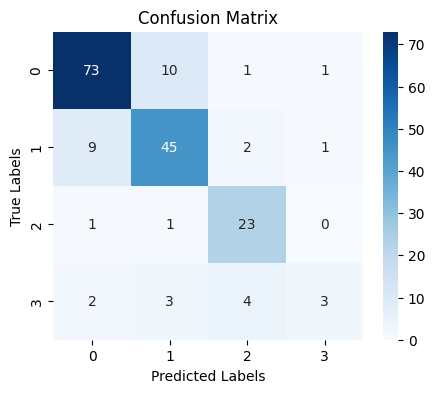

In [2]:
subj_index = "0558"
ind_558_acc, ind_558_f1 = predict_using_individual_model(subj_index)

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.785
F1-score (Macro): 0.401


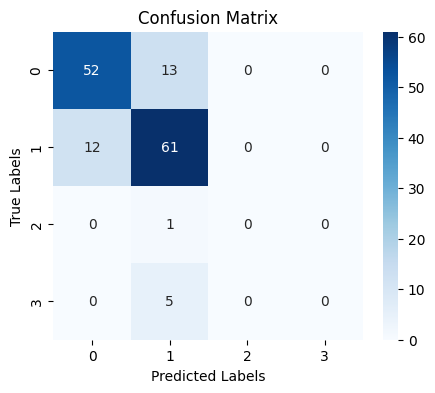

In [3]:
subj_index = "0565"
ind_565_acc, ind_565_f1 = predict_using_individual_model(subj_index)

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.622
F1-score (Macro): 0.317


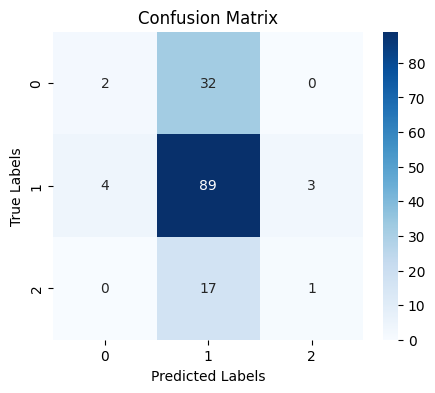

In [4]:
subj_index = "0560"
ind_560_acc, ind_560_f1 = predict_using_individual_model(subj_index)

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.736
F1-score (Macro): 0.595


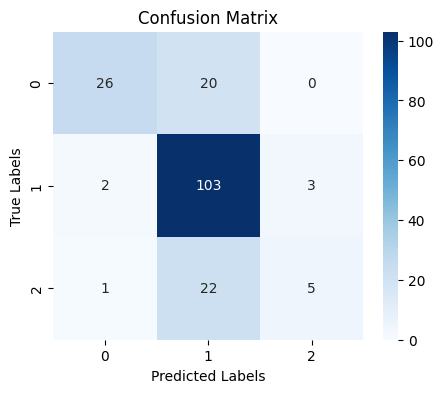

In [5]:
subj_index = "0571"
ind_571_acc, ind_571_f1 = predict_using_individual_model(subj_index)

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...Loading NoAugmenter augmenter...

Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.812
F1-score (Macro): 0.693


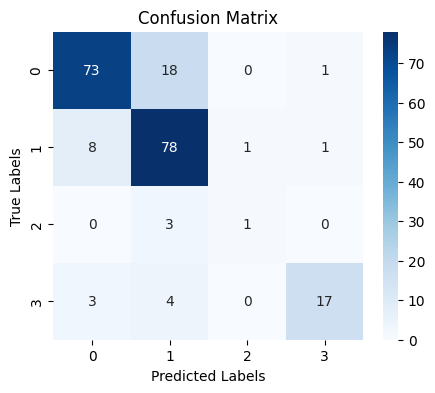

In [6]:
subj_index = "0583"
ind_583_acc, ind_583_f1 = predict_using_individual_model(subj_index)

### Individual Transfer Learning with Foundation Model

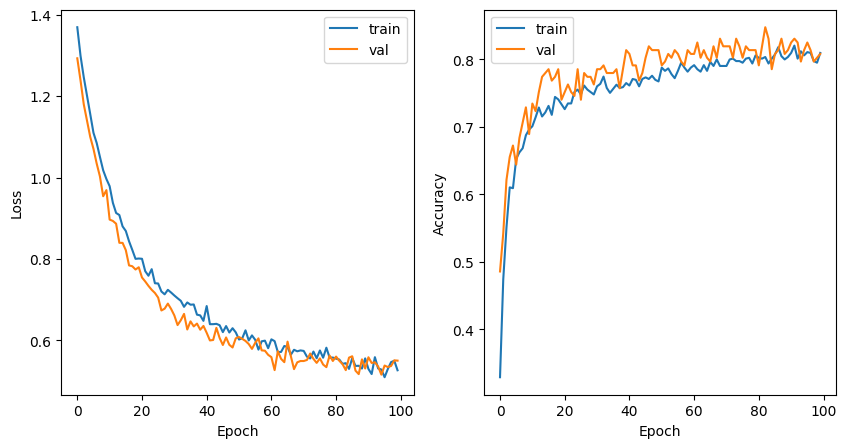

In [7]:
subj_index = "0558"
model_index = "0143"

loss_acc_plotting(subj_index, model_index)

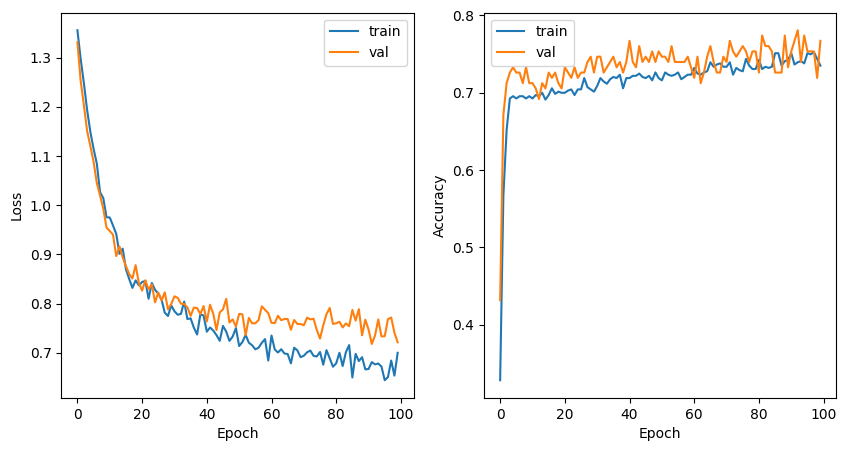

In [8]:
subj_index = "0560"
model_index = "0143"
loss_acc_plotting(subj_index, model_index)

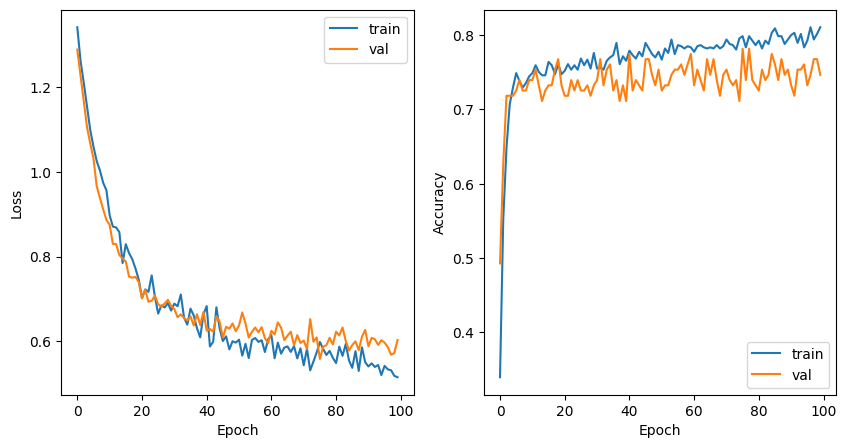

In [9]:
subj_index = "0565"
model_index = "0143"
loss_acc_plotting(subj_index, model_index)


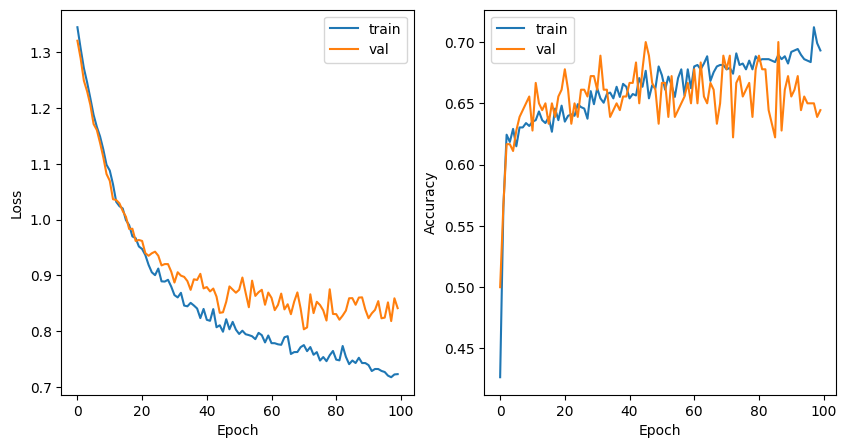

In [10]:
subj_index = "0571"
model_index = "0143"
loss_acc_plotting(subj_index, model_index)


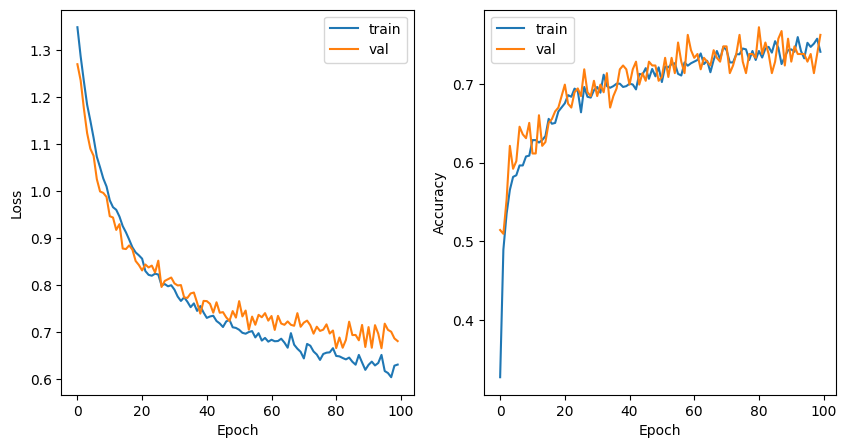

In [11]:
subj_index = "0583"
model_index = "0143"
loss_acc_plotting(subj_index, model_index)


### FM based Prediction Test

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.816
F1-score (Macro): 0.689


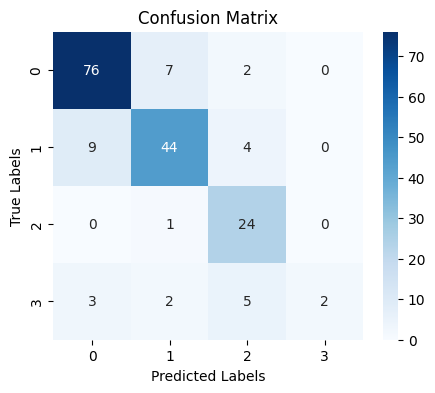

In [12]:
fm_558_acc, fm_558_f1 = predict_using_fm_classifier(subj_index="0558")

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.792
F1-score (Macro): 0.404


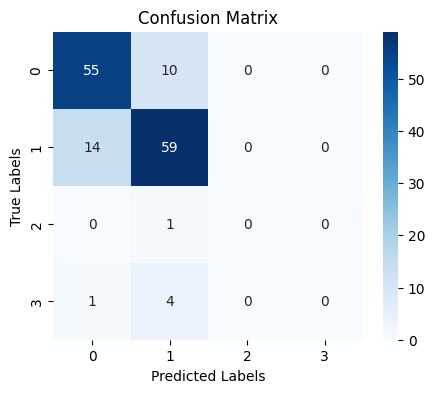

In [13]:
fm_565_acc, fm_565_f1 = predict_using_fm_classifier(subj_index="0565")

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.642
F1-score (Macro): 0.381


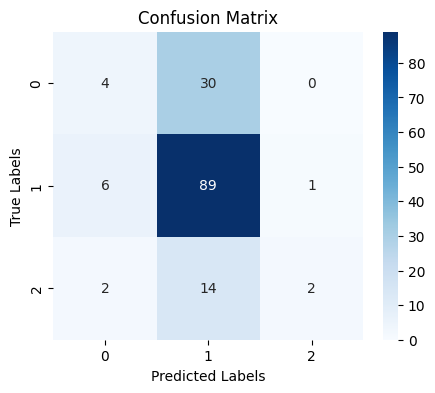

In [14]:
fm_560_acc, fm_560_f1 = predict_using_fm_classifier(subj_index="0560")

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.648
F1-score (Macro): 0.506


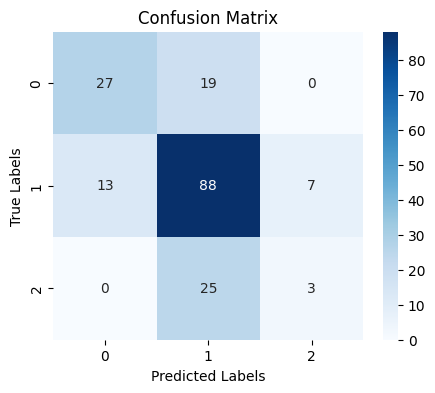

In [15]:
fm_571_acc, fm_571_f1 = predict_using_fm_classifier(subj_index="0571")

** Finished Initializing DeepSense Backbone **
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Loading NoAugmenter augmenter...
Accuracy: 0.716
F1-score (Macro): 0.52


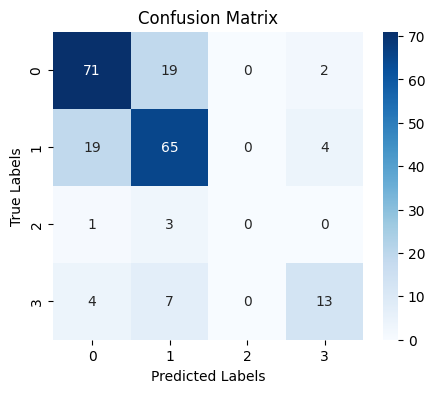

In [16]:
fm_583_acc, fm_583_f1 = predict_using_fm_classifier(subj_index="0583")

#### Compare individual Training VS. FM Training

In [17]:
print("Subject 0558")
print("----------------"*3)
print("Individual Model Accuracy: ", ind_558_acc)
print("*Foundation Model Accuracy: ", fm_558_acc)

print("Individual Model F1 Score: ", ind_558_f1)
print("*Foundation Model F1 Score: ", fm_558_f1)
print("----------------"*3)

if fm_558_acc > ind_558_acc:
    print("Foundation Model is better than Individual Model in terms of Accuracy")
    
if fm_558_f1 > ind_558_f1:
    print("Foundation Model is better than Individual Model in terms of F1 Score")

Subject 0558
------------------------------------------------
Individual Model Accuracy:  0.8044692737430168
*Foundation Model Accuracy:  0.8156424581005587
Individual Model F1 Score:  0.7059976028028766
*Foundation Model F1 Score:  0.689279948817521
------------------------------------------------
Foundation Model is better than Individual Model in terms of Accuracy


In [18]:
print("Subject 0565")
print("----------------"*3)
print("Individual Model Accuracy: ", ind_565_acc)
print("*Foundation Model Accuracy: ", fm_565_acc)

print("Individual Model F1 Score: ", ind_565_f1)
print("*Foundation Model F1 Score: ", fm_565_f1)
print("----------------"*3)

if fm_565_acc > ind_565_acc:
    print("Foundation Model is better than Individual Model in terms of Accuracy")

if fm_565_f1 > ind_565_f1:
    print("Foundation Model is better than Individual Model in terms of F1 Score")

Subject 0565
------------------------------------------------
Individual Model Accuracy:  0.7847222222222222
*Foundation Model Accuracy:  0.7916666666666666
Individual Model F1 Score:  0.4008967928256574
*Foundation Model F1 Score:  0.4043839758125472
------------------------------------------------
Foundation Model is better than Individual Model in terms of Accuracy
Foundation Model is better than Individual Model in terms of F1 Score


In [19]:
print("Subject 0560")
print("----------------"*3)
print("Individual Model Accuracy: ", ind_560_acc)
print("Foundation Model Accuracy: ", fm_560_acc)

print("Individual Model F1 Score: ", ind_560_f1)
print("Foundation Model F1 Score: ", fm_560_f1)
print("----------------"*3)

if fm_560_acc > ind_560_acc:
    print("Foundation Model is better than Individual Model in terms of Accuracy")
    
if fm_560_f1 > ind_560_f1:
    print("Foundation Model is better than Individual Model in terms of F1 Score")
    

Subject 0560
------------------------------------------------
Individual Model Accuracy:  0.6216216216216216
Foundation Model Accuracy:  0.6418918918918919
Individual Model F1 Score:  0.3171976171976172
Foundation Model F1 Score:  0.3805606034578885
------------------------------------------------
Foundation Model is better than Individual Model in terms of Accuracy
Foundation Model is better than Individual Model in terms of F1 Score


In [20]:
print("Subject 0571")
print("----------------"*3)
print("Individual Model Accuracy: ", ind_571_acc)
print("Foundation Model Accuracy: ", fm_571_acc)

print("Individual Model F1 Score: ", ind_571_f1)
print("Foundation Model F1 Score: ", fm_571_f1)
print("----------------"*3)

if fm_571_acc > ind_571_acc:
    print("Foundation Model is better than Individual Model in terms of Accuracy")
    
if fm_571_f1 > ind_571_f1:
    print("Foundation Model is better than Individual Model in terms of F1 Score")
    

Subject 0571
------------------------------------------------
Individual Model Accuracy:  0.7362637362637363
Foundation Model Accuracy:  0.6483516483516484
Individual Model F1 Score:  0.595113453374323
Foundation Model F1 Score:  0.5063783489732082
------------------------------------------------


In [21]:
print("Subject 0583")
print("----------------"*3)
print("Individual Model Accuracy: ", ind_583_acc)
print("Foundation Model Accuracy: ", fm_583_acc)

print("Individual Model F1 Score: ", ind_583_f1)
print("Foundation Model F1 Score: ", fm_583_f1)
print("----------------"*3)

if fm_571_acc > ind_583_acc:
    print("Foundation Model is better than Individual Model in terms of Accuracy")
    
if fm_571_f1 > ind_583_f1:
    print("Foundation Model is better than Individual Model in terms of F1 Score")
    

Subject 0583
------------------------------------------------
Individual Model Accuracy:  0.8125
Foundation Model Accuracy:  0.7163461538461539
Individual Model F1 Score:  0.6925825972497408
Foundation Model F1 Score:  0.5195737914616163
------------------------------------------------
